# Using PyQIR Parser
Most of the examples here of the visualization and interop come from this PR by @cgranade: https://github.com/microsoft/qsharp-compiler/pull/1221/

## How does the package work?

Just like any Python package, we need to import the package and then we want to load the QIR file we want to parse.

In [80]:
import pprint as pp

In [81]:
import pyqir_parser as pqp
#mod = pqp.QirModule("bernstein_vazirani.bc")
mod = pqp.QirModule("teleportchain.baseprofile.bc")

In [ ]:
dir(pqp)

We can then look at the attributes and functions that are a part of the `QirModule` class. Of particular interest are  
```
'functions',
'get_entrypoint_funcs',
'get_func_by_name',
'get_funcs_by_attr',
'get_interop_funcs'
```
as they are what allows us to drill into the module.

In [82]:
list(filter(lambda a: not(a.startswith('__')), dir(mod)))

['entrypoint_funcs',
 'functions',
 'get_func_by_name',
 'get_funcs_by_attr',
 'interop_funcs',
 'module']

We can then look at what functions are listed in the QIR program we imported.

In [83]:
[function.name for function in mod.functions]

['TeleportChain__DemonstrateTeleportationUsingPresharedEntanglement__Interop']

We can either use an index on the mod.functions list or the `get_func_by_name` function.

In [84]:
func_name = "TeleportChain__DemonstrateTeleportationUsingPresharedEntanglement__Interop"
func = mod.get_func_by_name(func_name)
print(func)

In [85]:
list(filter(lambda a:  not(a.startswith('__')), dir(func)))

['blocks',
 'func',
 'get_attribute_value',
 'get_block_by_name',
 'get_instruction_by_output_name',
 'name',
 'parameters',
 'required_qubits',
 'required_results',
 'return_type']

Now that we have a function, let's look at it's blocks.

In [25]:
list(filter(lambda a:  not(a.startswith('__')), dir(func.blocks[0])))

['block',
 'get_phi_pairs_by_source_name',
 'instructions',
 'name',
 'phi_nodes',
 'terminator']

In [37]:
[block.name for block in func.blocks]

['entry',
 'then0__1.i.i.i',
 'continue__1.i.i.i',
 'then0__2.i.i.i',
 'TeleportChain__TeleportQubitUsingPresharedEntanglement__body.2.exit.i',
 'then0__1.i.i1.i',
 'continue__1.i.i2.i',
 'then0__2.i.i3.i',
 'TeleportChain__DemonstrateTeleportationUsingPresharedEntanglement__body.1.exit']

To look at the function another way, let's use a visualization tool to see the relationship between the blocks.

In [86]:
import retworkx as rx
import retworkx.visualization
import matplotlib.pyplot as plt

def control_flow_graph(func : pqp.PyQirFunction) -> "rx.Digraph":
    cfg = rx.PyDiGraph(check_cycle=False, multigraph=True)
    blocks = func.blocks
    block_indices = {
        block.name: cfg.add_node(block)
        for block in blocks
    }

    idx_return = cfg.add_node("Return")
    idx_bottom = None

    for idx_block, block in enumerate(blocks):
        term = block.terminator
        if isinstance(term, pqp.QirCondBrTerminator):
            cfg.add_edge(idx_block, block_indices[term.true_dest], True)
            cfg.add_edge(idx_block, block_indices[term.false_dest], False)
        elif isinstance(term, pqp.QirBrTerminator):
            cfg.add_edge(idx_block, block_indices[term.dest], ())
        elif isinstance(term, pqp.QirRetTerminator):
            cfg.add_edge(idx_block, idx_return, ())
        elif isinstance(term, pqp.QirSwitchTerminator):
            print(f"Not yet implemented: {term} in {block}")
        elif isinstance(term, pqp.QirUnreachableTerminator):
            if idx_bottom is None:
                idx_bottom = cfg.add_node("⊥")
            cfg.add_edge(idx_block, idx_bottom)
        else:
            print(f"Not yet implemented: {term} in {block}")

    return cfg

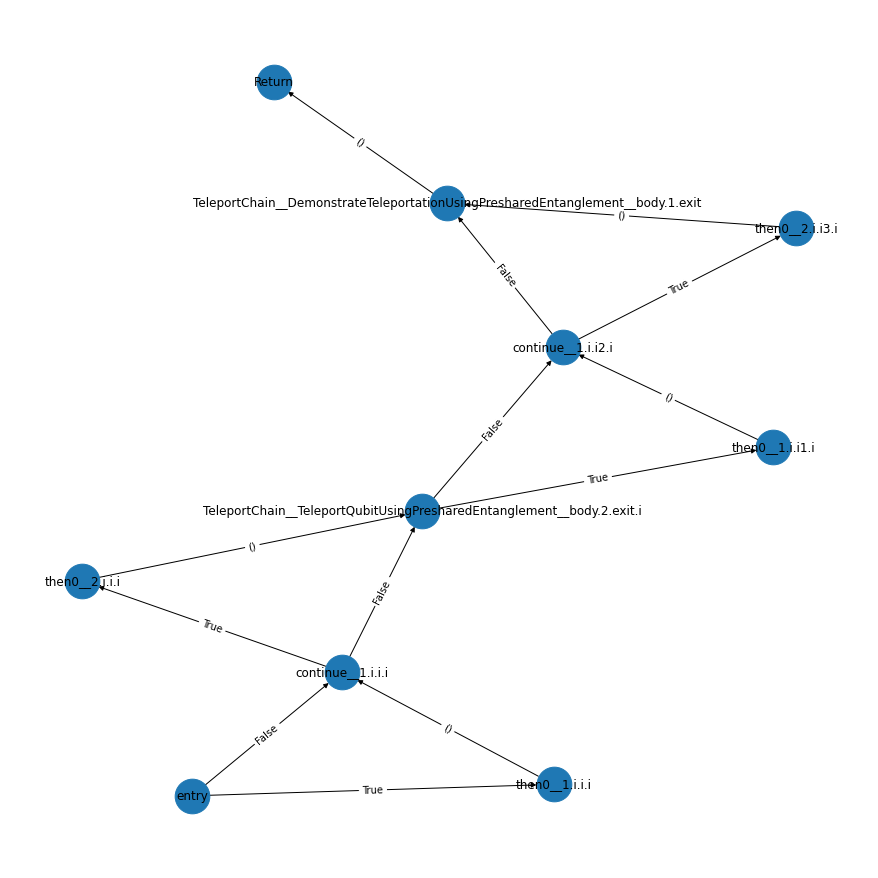

In [87]:
plt.figure(figsize=(12, 12))
rx.visualization.mpl_draw(
    control_flow_graph(func),
    with_labels=True,
    labels=lambda block: getattr(block, "name", block),
    edge_labels=str,
    node_size=1200
)

Looking at all of the instructions in this function in the QIR program:

In [88]:
{block.name : [(inst.output_name, inst.type) for inst in block.instructions] for block in func.blocks}

{'entry': [(None, <pyqir_parser.parser.QirVoidType at 0x22bb1c57dc0>),
  (None, <pyqir_parser.parser.QirVoidType at 0x22bb1d0b580>),
  (None, <pyqir_parser.parser.QirVoidType at 0x22bb1d0b0d0>),
  (None, <pyqir_parser.parser.QirVoidType at 0x22bb1d0b340>),
  (None, <pyqir_parser.parser.QirVoidType at 0x22bb1d0b3d0>),
  (None, <pyqir_parser.parser.QirVoidType at 0x22bb1d0b760>),
  (None, <pyqir_parser.parser.QirVoidType at 0x22bb1d0b250>),
  (None, <pyqir_parser.parser.QirVoidType at 0x22bb1d0beb0>),
  (None, <pyqir_parser.parser.QirVoidType at 0x22bb016cc70>),
  (None, <pyqir_parser.parser.QirVoidType at 0x22bb016c7c0>),
  ('0', <pyqir_parser.parser.QirIntegerType at 0x22bb1bbc070>)],
 'then0__1.i.i.i': [(None,
   <pyqir_parser.parser.QirVoidType at 0x22bb1e14310>)],
 'continue__1.i.i.i': [(None,
   <pyqir_parser.parser.QirVoidType at 0x22bb1c57c10>),
  (None, <pyqir_parser.parser.QirVoidType at 0x22bb1c57400>),
  ('1', <pyqir_parser.parser.QirIntegerType at 0x22bb1c57910>)],
 'then0__

## Testing export example
Want to import a bitcode file of a QIR program and dump it out to a cirq or qiskit object.

This is most simply viewed as an function on a block in a QIR function, so let's try this on the blocks from the QIR program loaded above. First we have to be sure that the block actually represents a circuit.

In [118]:
instructions_by_block = [
    [
        f"call {inst.func_name}({inst.func_args})"
        if isinstance(inst, pqp.QirCallInstr) else
        f"inst {inst}"
        if isinstance(inst, pqp.QirInstr) else
        inst
        for inst in block.instructions
    ]
    for block in func.blocks 
]

In [119]:
pp.pprint(instructions_dict_of_func)

{'TeleportChain__TeleportQubitUsingPresharedEntanglement__body.2.exit.i': [<pyqir_parser.parser.QirQisCallInstr object at 0x0000022BB258EC10>,
 'continue__1.i.i.i': [<pyqir_parser.parser.QirQisCallInstr object at 0x0000022BB260B7C0>,
 'continue__1.i.i2.i': [<pyqir_parser.parser.QirQisCallInstr object at 0x0000022BB258EA30>,
 'entry': [<pyqir_parser.parser.QirQisCallInstr object at 0x0000022BB2608250>,
 'then0__1.i.i.i': [<pyqir_parser.parser.QirQisCallInstr object at 0x0000022BB2608D90>],
 'then0__1.i.i1.i': [<pyqir_parser.parser.QirQisCallInstr object at 0x0000022BB258EEB0>],
 'then0__2.i.i.i': [<pyqir_parser.parser.QirQisCallInstr object at 0x0000022BB25DED60>],
 'then0__2.i.i3.i': [<pyqir_parser.parser.QirQisCallInstr object at 0x0000022BB25E8DC0>]}


### Open QASM2.0

### QuTiP

In [67]:
import pyqir_parser as pqp

#mod = pqp.QirModule("bernstein_vazirani.bc")
mod = pqp.QirModule("teleportchain.baseprofile.bc")
func_name = "TeleportChain__DemonstrateTeleportationUsingPresharedEntanglement__Interop"
func = mod.get_func_by_name(func_name)

from abc import ABCMeta, abstractmethod
from typing import Any, Callable, Dict, List, Optional, Set, Union, Generic, TypeVar
TOutput = TypeVar('TOutput')
try:
    import qiskit as qk
except ImportError:
    qk = None
try:
    import qutip as qt
    import qutip.qip.circuit
    import qutip.qip.operations
except ImportError:
    qt = None

In [62]:
circuits = {b.name : OpenQasm20Exporter(b).export() for b in func.blocks if is_circuit_like(b)}

In [63]:
[print(f"""-------------
{circuit}

""") for block, circuit in circuits.items()]

-------------
// Generated from QIR block entry.
OPENQASM 2.0;
include "qelib1.inc";

qreg q[6];
creg c[1];
h q[0];
CX q[0], q[1];
h q[2];
CX q[2], q[3];
h q[4];
CX q[4], q[5];
CX q[1], q[2];
h q[1];
measure q[1] -> c[0];
// Requires nonstandard reset gate:
reset q[1];
// %0 = c[0]


-------------
// Generated from QIR block then0__1.i.i.i.
OPENQASM 2.0;
include "qelib1.inc";

qreg q[1];
z q[0];


-------------
// Generated from QIR block continue__1.i.i.i.
OPENQASM 2.0;
include "qelib1.inc";

qreg q[1];
creg c[1];
measure q[0] -> c[0];
// Requires nonstandard reset gate:
reset q[0];
// %1 = c[0]


-------------
// Generated from QIR block then0__2.i.i.i.
OPENQASM 2.0;
include "qelib1.inc";

qreg q[1];
x q[0];


-------------
// Generated from QIR block TeleportChain__TeleportQubitUsingPresharedEntanglement__body.2.exit.i.
OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];
creg c[1];
CX q[0], q[1];
h q[0];
measure q[0] -> c[0];
// Requires nonstandard reset gate:
reset q[0];
// %2 = c[0]


[None, None, None, None, None, None, None, None]

In [66]:
QiskitExporter(func.blocks[0]).export().draw()

┌───┐                       
q_0: ┤ H ├──■────────────────────
     └───┘┌─┴─┐     ┌───┐┌─┐     
q_1: ─────┤ X ├──■──┤ H ├┤M├─|0>─
     ┌───┐└───┘┌─┴─┐└───┘└╥┘     
q_2: ┤ H ├──■──┤ X ├──────╫──────
     └───┘┌─┴─┐└───┘      ║      
q_3: ─────┤ X ├───────────╫──────
     ┌───┐└───┘           ║      
q_4: ┤ H ├──■─────────────╫──────
     └───┘┌─┴─┐           ║      
q_5: ─────┤ X ├───────────╫──────
          └───┘           ║      
c: 1/═════════════════════╩══════
                          0